# ETR: Enhancing Transformation Reduction for Reducing Dimensionality and Classification Complexity in Hyperspectral Images 

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import keras
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode

from numpy.core.fromnumeric import shape
from skimage.morphology import reconstruction
from sklearn.preprocessing import QuantileTransformer


import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import pandas as pd
import time
import seaborn as sn

init_notebook_mode(connected=True)
%matplotlib inline

# Data Loading

In [46]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'../data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'KSC':
        data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
        labels = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt'] 
    elif name == 'LK':
        data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
        labels = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
    elif name == 'HC':
        data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
        labels = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
    elif name == 'Di':
        data = sio.loadmat(os.path.join(data_path, 'Dioni.mat'))['Dioni']
        labels = sio.loadmat(os.path.join(data_path, 'Dioni_GT.mat'))['Dioni_gt']
    elif name == 'Lk':
        data = sio.loadmat(os.path.join(data_path, 'Loukia.mat'))['Loukia']
        labels = sio.loadmat(os.path.join(data_path, 'Loukia_GT.mat'))['Loukia_gt']
    return data, labels

In [47]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [49]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [50]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [51]:
def first_step(X, orgin, numComponents):

  # Calculate the covariance matrix first
  
  correlation_matrix = np.corrcoef(orgin.T)
 
  covariance_matrix = np.cov(X.T)   # The result is a Positive semidefinite matrix
  
  final_matrix = covariance_matrix - correlation_matrix
  
  # Eigendecomposition of the covariance
  eigen_values, eigen_vectors = np.linalg.eig(final_matrix)
  # Calculate the variance explained on each of those components
  variance_explained = [(i/sum(eigen_values))*100 for i in eigen_values]
  # Calculate the cumulative sum of variance explained
  cumulative_variance_explained = np.cumsum(variance_explained)
  #Taking two components and create a projection matrix
  projection_matrix = (eigen_vectors.T[:][:numComponents]).T
  
  # Calculate the product of X (standardized original data multiply by eigenvectors)

  X_w = X.dot(projection_matrix)

  return X_w

In [52]:
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']

  return df

In [53]:
def ETR(X1, y1, band_no, status = 'max', min_no = 1, numComponents=15):
  try:

    df = extract_pixels(X1, y1)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    
    X = first_step(X,X.iloc[:, :], numComponents)

    # the second step of the ETR method
    X_mean = X
    if status == 'max':
      X_mean['mean'] = X_mean.max(axis=1)* min_no

    elif status == 'mean':
      X_mean['mean'] = X_mean.mean(axis=1)

    else:
      print("You should choose the max or mean status, and if max add the sigma value")
      return None

    Avr = [X_mean['mean']]
    rep_Avr = np.repeat(Avr, numComponents)
    rep_Avr =np.reshape(rep_Avr, (-1,numComponents))
    main_X = X.iloc[:, :-1]
    seed = main_X - rep_Avr
    
    dilated = reconstruction(seed.values, main_X.values)    
    
    scaler = QuantileTransformer(n_quantiles=15, random_state=0,output_distribution='normal') #
    scaler = scaler.fit_transform(dilated)
   
  except:
    print("Please use max status with sigma value rather than the min status")
  
  return scaler, y 

# Dataset

In [54]:
dataset = 'IP'
numComponents = 30
test_ratio = 0.8
windowSize = 15
X, y11 = loadData(dataset)
h1 = X.shape[0]
w1 = X.shape[1]
band_no = X.shape[2]
X.shape, y11.shape

((145, 145, 200), (145, 145))

In [55]:
status = 'mean' #'mean' or 'max' choosing the status is used to enhance classes' variation.
sigma = 0.30 # σ is used to reduce the distance between values of the same class.

X1, y1 = ETR(X,y11, band_no, status, sigma, numComponents)


In [56]:
q = pd.concat([pd.DataFrame(data = X1), pd.DataFrame(data = y1.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,numComponents+1)]+['class']#(1, 41)

In [57]:
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-22,PC-23,PC-24,PC-25,PC-26,PC-27,PC-28,PC-29,PC-30,class
0,-0.673942,-0.404378,-0.172611,-0.167018,0.751451,0.806365,-0.281443,0.657188,1.067571,-0.249021,...,-5.199338,-0.771524,-1.522975,-0.719239,0.601585,-5.199338,0.483533,5.199338,5.199338,3
1,-0.938419,0.766347,-0.642394,0.912042,-0.178643,0.806365,-0.472208,-0.522158,1.067571,0.430636,...,-5.199338,0.631275,-1.522975,0.558803,0.345849,-5.199338,0.612624,5.199338,-1.597026,3
2,-1.056634,0.766347,-0.866489,1.309854,-0.445847,0.806365,-0.388068,-0.414204,1.067571,-0.668600,...,-5.199338,0.964026,-1.522975,0.558803,1.051999,-5.199338,-0.302923,5.199338,5.199338,3
3,-0.929753,0.766347,-0.652155,0.875772,-0.175692,0.806365,-0.608421,-0.503610,1.067571,0.281769,...,-5.199338,0.680727,-1.522975,0.558803,0.152014,-5.199338,0.784383,5.199338,-1.540344,3
4,-0.676138,0.111213,-0.023409,0.161642,0.631514,0.806365,-1.342871,0.829025,1.067571,-0.252901,...,-5.199338,-0.220700,-1.522975,-0.121170,0.236461,-5.199338,0.459529,5.199338,5.199338,3


In [58]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=345, stratify=y)

In [59]:
from sklearn.svm import SVC
#Using the SVM to classify the output of the ETR method
svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)
import time
start = time.time()
svm.fit(X_train, y_train)
end = time.time()
Train_time = end - start
print(Train_time)

In [61]:
test_start = time.time()
y_pred = svm.predict(X_test)
test_end = time.time()
TEST_TIME = test_end - test_start
print(TEST_TIME)

In [68]:
from operator import truediv
def AA_andEachClassAccuracy2(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [82]:
import pandas as pd
import numpy as np
import time
import seaborn as sn
def reports2 (X_test,y_test,name):
    start = time.time()
    Y_pred = X_test#svm.predict(X_test)
    #y_pred = np.argmax(Y_pred, axis=1)
    end = time.time()

    TESTING_TIME = end - start
    print(TESTING_TIME)
    if dataset == 'IP':
        names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif dataset == 'SA':
        names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif dataset == 'PU':
        names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif dataset == 'KSC':
            names = ["Scrub", "Willow swamp",
                            "Cabbage palm hammock", "Cabbage palm/oak hammock",
                            "Slash pine", "Oak/broadleaf hammock",
                            "Hardwood swamp", "Graminoid marsh", "Spartina marsh",
                            "Cattail marsh", "Salt marsh", "Mud flats", "Water"]
        
    elif dataset == 'Di':
        names = ["Scrub", "Willow swamp",
                        "Cabbage palm hammock", "Cabbage palm/oak hammock",
                        "Slash pine", "Oak/broadleaf hammock",
                        "Hardwood swamp", "Graminoid marsh", "Spartina marsh",
                        "Cattail marsh", "Salt marsh", "Mud flats"]
    elif dataset == 'Lk':
        names = ["Dense Urban Fabric", "Mineral Extraction Sites",
                        "Non Irrigated Arable Land", "Fruit Trees",
                        "Olive Groves","Broad-Leaved Forest", "Coniferous Forest","Mixed Forest",
                        "Dense Sclerophyllous Vegetation", "Sparce Sclerophyllous Vegetation", "Sparcely Vegetated Areas",
                        "Rocks and Sand", "Water", "Coastal Water"]
        
    classification = classification_report(y_test, y_pred, target_names=names)
    oa = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    ###################################
    clsf_report = pd.DataFrame(classification_report(y_test, y_pred, target_names=names, output_dict=True)).transpose()
    clsf_report.to_csv('/results/Classification Report.csv', index= True)
    #print(classification_report(y_test, y_pred, target_names = names))
    #########################
    df_cm = pd.DataFrame(confusion, columns=np.unique(names), index = np.unique(names))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,8))
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
    #plt.savefig('confusion_matrix_model2.png', dpi=300)
    ##############
    each_acc, aa = AA_andEachClassAccuracy2(confusion)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    
    return TESTING_TIME, classification, confusion, oa*100, each_acc*100, aa*100, kappa*100

9.5367431640625e-07
                              precision    recall  f1-score   support

                     Alfalfa       0.77      0.62      0.69        37
                 Corn-notill       0.75      0.79      0.77      1143
                Corn-mintill       0.82      0.79      0.80       664
                        Corn       0.81      0.67      0.73       190
               Grass-pasture       0.92      0.92      0.92       386
                 Grass-trees       0.94      0.99      0.96       584
         Grass-pasture-mowed       0.75      0.95      0.84        22
               Hay-windrowed       0.99      0.99      0.99       382
                        Oats       0.89      0.50      0.64        16
              Soybean-notill       0.84      0.84      0.84       778
             Soybean-mintill       0.86      0.88      0.87      1964
               Soybean-clean       0.82      0.75      0.79       475
                       Wheat       0.98      0.99      0.98       164

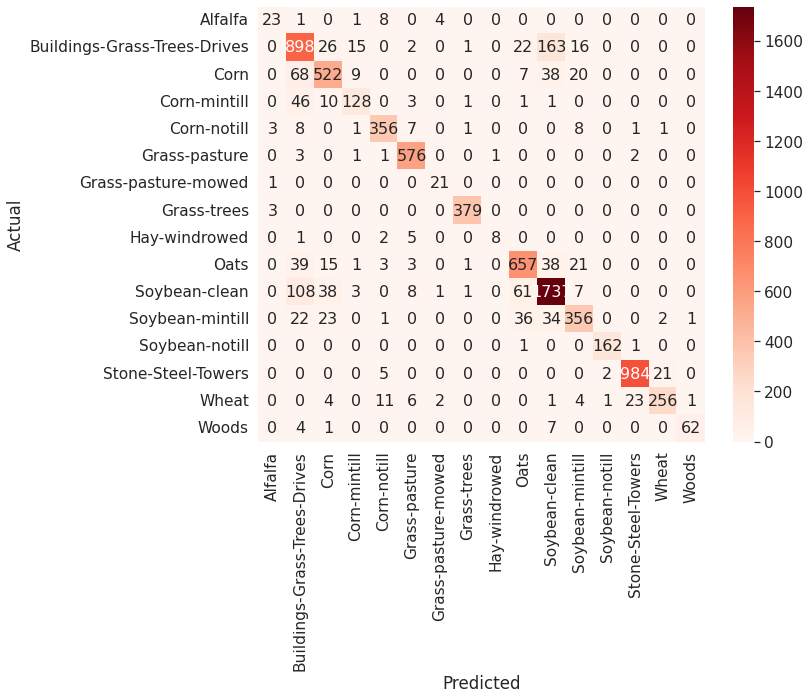

In [85]:
TESTING_TIME, classification, confusion, oa, each_acc, aa, kappa = reports2(y_pred,y_test, dataset)
df_clas = classification
classification = str(classification)
confusion = str(confusion)
element_mean = np.mean(each_acc, axis=0)
element_std = np.std(each_acc, axis=0)
file_name = "/results/SVM_classification_"+dataset+".txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Pn_components : '.format(numComponents))
    x_file.write('\n')
    x_file.write('{} Training Time 2 (s)'.format(Train_time))
    x_file.write('\n')
    x_file.write('{} Test Time: (S)'.format(TEST_TIME))
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}+{} mean_KAPPA ± std_KAPPA is:'.format(str(np.mean(kappa)), str(np.std(kappa))))
    x_file.write('\n')
    x_file.write('{}+{} mean_OA ± std_OA is: (%)'.format(str(np.mean(oa)), str(np.std(oa))))
    x_file.write('\n')
    x_file.write('{}+{} mean_AA ± std_AA is:'.format(str(np.mean(aa)), str(np.std(aa))))
    x_file.write('\n')
    x_file.write('{} AMean of all elements in confusion matrix: (%)'.format(str(element_mean)))
    x_file.write('\n')
    x_file.write('{} Standard deviation of all elements in confusion matrix: (%)'.format(str(element_std)))
    x_file.write('\n')
    x_file.write('==============================\n')
    x_file.write('{}classification Report:'.format(classification))
    x_file.write('\n')
    x_file.write('===============================\n')
    x_file.write('{} confusion Matrix:'.format(confusion))